In [1]:
%matplotlib inline
# Grub AI Notebook
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
import textblob as tb
from gensim.sklearn_api import W2VTransformer
import pickle as pkl
from wordcloud import WordCloud
import csv
import re
import string 
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.model_selection import train_test_split



In [2]:
import tensorflow as tf 


In [3]:
# Import data
reader = pd.read_json("../data/yelp_academic_dataset_review.json", lines=True, chunksize=500000)


In [4]:
#Get dataframe
review_df = None
for chunk in reader:
    review_df = chunk.filter(items=['review_id', 'stars', 'text'])
    break
print(review_df.shape)
print(review_df.stars.value_counts())

(500000, 3)
5    220375
4    112802
1     70468
3     55778
2     40577
Name: stars, dtype: int64


In [9]:
balanced_review_df = review_df.groupby('stars')
balanced_review_df = balanced_review_df.apply(lambda x: x.sample(balanced_review_df.size().min()).reset_index(drop=True))
print(balanced_review_df.stars.value_counts())
review_df = balanced_review_df

5    40577
4    40577
3    40577
2    40577
1    40577
Name: stars, dtype: int64


<AxesSubplot:>

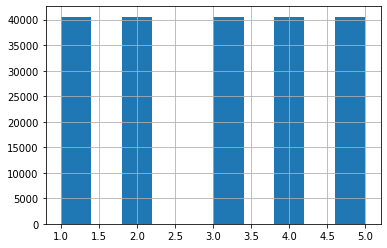

In [10]:
review_df['stars'].hist()

In [11]:
review_df.iloc[[1,5,6]]

review_id  stars  \
stars                                    
1     1  O885mg2dWsIy4k5InHImkA      1   
      5  EZQjgsNxN3TysrEy_LDy0g      1   
      6  vGykdr8E27ANMKvHyx9OPQ      1   

                                                      text  
stars                                                       
1     1  We have always been happy with the doctors but...  
      5  Worst service ever, waited 2 hours for our foo...  
      6  Long story short. I waited over a week for a l...

In [42]:
#tokenize reviews function
snowball = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [snowball.stem(word) for word in tokenizer.tokenize(text.lower())]

In [12]:
#Tf-idf vectorize reviews function
def vectorize_tfidf(reviews):
    vectorizer = TfidfVectorizer(stop_words = 'english', tokenizer = tokenize, max_features = 1000)
    X = vectorizer.fit_transform(reviews)
    words = vectorizer.get_feature_names()
    return X, words

In [13]:
#Word2Vec vectorize reviews function
def vectorize_wordvec(reviews):
    vectorizer = W2VTransformer(size = 100, min_count = 1, seed = 1)
    Y = vectorizer.fit_transform(reviews)
    words = vectorizer.get_feature_names()
    return Y, words

In [45]:
Y, words = vectorize_wordvec(review_df['text'].values)
print(Y)
print(words)

KeyboardInterrupt: 

In [14]:
def glove_model():
    # max number of unique words 
    max_features = 20000
    # max number of words from review to use
    maxlen = 200

    # File path
    embedding_file = '../data/glove.twitter.27B.200d.txt'

    # read in embeddings
    # def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32') 
    # embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file, encoding='utf8'))]


    embeddings_index = pd.read_table(embedding_file, sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

    return embeddings_index

In [10]:
glove_embedding = glove_model()
pkl.dump(glove_embedding, open('../data/glove','wb'))
print(glove_embedding)

KeyboardInterrupt: 

In [15]:
glove_embedding = pkl.load(open('../data/glove','rb'))

In [13]:
def print_clusters(K = 5, num_words = 20):
    labels_color_map = {
        0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
        5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
    }
    pca_num_components = 2
    company_df = review_df
    # company_name = company_df['name'].unique()[0]
    reviews = company_df['text'].values
    # print(len(reviews))
    # print(reviews)
    X, words = vectorize_tfidf(reviews)
    # Y, wordsV = vectorize_wordvec(reviews)
    # Z, wordsG = vectorize_glove(reviews)
    denseX = X.todense()
    # denseY = Y.todense()
    # print(denseX)
    # print(denseX.shape)
    # print(denseY)
    # print(denseY.shape)
    elbow = {2:0,3:0,4:0,5:0}
    for k in range(2,6):
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(X)
        elbow[k] += kmeans.inertia_
    # for k in elbow.keys():
    #     elbow[k] = elbow[k]/10
    
    kmeans = KMeans(n_clusters = 3)
    kmeans.fit(X)

    common_words = kmeans.cluster_centers_.argsort()[:,-1:-num_words-1:-1]
    print(common_words.shape)
    print(kmeans.labels_)
    plt.figure()
    plt.plot(list(elbow.keys()), list(elbow.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.show()

    reduced_data = PCA(n_components=3).fit_transform(denseX)
    fig, ax = plt.subplots()
    for index, instance in enumerate(reduced_data):
        print(reduced_data[index])
        pca_comp_1, pca_comp_2 = reduced_data[index]
        # color = labels_color_map[kmeans.labels_[index]]
        color = labels_color_map[reviews.iloc[index][1]]
        ax.scatter(pca_comp_1, pca_comp_2, c=color) 
    plt.show()


    mydict = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
    # print(mydict)
    # print(kmeans.cluster_centers_.argsort()[:,-1:-num_words-1:-1])
    # print(len(words))
    print('Groups of ' + str(num_words) + ' words typically used together in reviews for ' + \
        "all businesses")
    print(mydict[0].tolist())
    # print()
    print([company_df.iloc[mydict[key].tolist()]["stars"].mean() for key in mydict.keys()])

    for num, centroid in enumerate(common_words):
        print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

In [14]:
print_clusters("")

KeyboardInterrupt: 

In [ ]:
#Supervised learning portion

                review_id  stars  \
0  xQY8N_XvtGbearJ5X4QryQ      2   
1  UmFMZ8PyXZTY2QcwzsfQYA      1   
2  LG2ZaYiOgpr2DK_90pYjNw      5   
3  i6g_oA9Yf9Y31qt0wibXpw      1   
4  6TdNDKywdbjoTkizeMce8A      4   

                                                text  
0  As someone who has worked with many museums, I...  
1  I am actually horrified this place is still in...  
2  I love Deagan's. I do. I really do. The atmosp...  
3  Dismal, lukewarm, defrosted-tasting "TexMex" g...  
4  Oh happy day, finally have a Canes near my cas...  


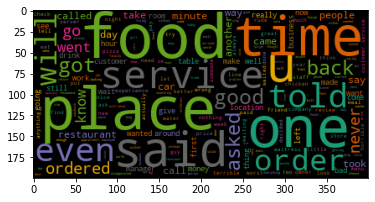

In [12]:

#doing fuck shit ignore this
print(review_df.head())
n_posts = 1000
q1 = ' '.join(review_df[review_df['stars'] == 1]['text'].str.lower().values[:n_posts])

wordcloud1 = WordCloud(max_font_size=None, colormap='Dark2').generate(q1)

plt.imshow(wordcloud1)


In [13]:
# glove_embedding = pkl.load(open('../data/glove.txt','rb'))

word2vec_output = '..\data\glove.txt.word2vec'
glove_path = '..\data\glove.twitter.27B.200d.txt'
glove2word2vec(glove_path, word2vec_output)



(1193514, 200)

In [16]:
glove_model = pkl.load(open('..\data\glove_model.p','rb'))
# glove_model = KeyedVectors.load_word2vec_format(word2vec_output, binary=False) 


In [14]:
pkl.dump(glove_model, open("..\data\glove_model.p","wb"))

In [17]:
# get feature vector for each word in review
# average those vectors
# append to reviews array


def getFeatureVectorForReview(glove_model):    
    texts = review_df['text']
    reviews = []
    index = 0
    indices = []
    for text in texts:
        isNan = True

        vectors = []
        count = 0
        review = re.sub('['+string.punctuation+']', '', text).split() 
        
        for word in review:
            try:
                vectors.append(glove_model.get_vector(word))
                isNan =False
            except KeyError:

                count += 1
        vector = np.mean(np.array(vectors), axis=0)
        if isNan:
            indices.append(index)
        else:
            reviews.append(vector)
            index += 1

    
    return np.stack(reviews, axis=0), indices





In [18]:
# try:
#     print(glove_model.get_vector('As'))


# except KeyError:
#     print('not found')

reviews, indices = getFeatureVectorForReview(glove_model)

for index in indices:
    review_df = review_df.drop([review_df.index[index]])

print(reviews.shape)



(202812, 200)


In [19]:
#one hot encoding the reviews
ratings = []

for rating in review_df['stars']:
    starRating = np.zeros(5)
    starRating[rating-1] = 1
    ratings.append(starRating)
ratings = np.array(ratings)
print(ratings.shape)

(202812, 5)


In [20]:

x_train, x_test, y_train, y_test = train_test_split(reviews, ratings, test_size= 0.3)
print(len(y_train))


141968


In [21]:
from time import time
from keras.callbacks import TensorBoard

model = Sequential()
model.add(Dense(50, input_dim=len(x_train[0]), activation='relu'))
model.add(Dense(28, activation='relu'))
model.add(Dense(28, activation='relu'))
model.add(Dense(5, activation='softmax'))

tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [22]:
model.fit(x_train, y_train, epochs=200, batch_size=64, callbacks=[tensorboard])
model.save("model_batch64")


Epoch 1/200
   1/2219 [..............................] - ETA: 1s - loss: 1.6248 - accuracy: 0.2812WARNING:tensorflow:From C:\Users\Rithik Gavvala\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2219/2219 [==============================] - 3s 1ms/step - loss: 1.1532 - accuracy: 0.5024
Epoch 2/200
2219/2219 [==============================] - 3s 1ms/step - loss: 1.0958 - accuracy: 0.5274
Epoch 3/200
2219/2219 [==============================] - 3s 1ms/step - loss: 1.0840 - accuracy: 0.5328
Epoch 4/200
2219/2219 [==============================] - 3s 1ms/step - loss: 1.0762 - accuracy: 0.5354
Epoch 5/200
2219/2219 [==============================] - 3s 1ms/step - loss: 1.0703 - accuracy: 0.5372
Epoch 6/200
2219/2219 [==============================] - 3s 1ms/step - loss: 1.0647 - accu

In [23]:


def predictReview(text):
    vector_text= vectorizeReview(text)
    predict = model.predict(vector_text)
    print(predict)
    print(np.argmax(predict)+1)

    

In [43]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=2)])


In [44]:
_, accuracy = model.evaluate(x_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

1902/1902 [==============================] - 2s 1ms/step - loss: 1.1740 - top_k_categorical_accuracy: 0.8034
Accuracy: 80.34


In [45]:
input_str = ('''Taco Bell Cantina Bowl: B+, but the guac was NOT extra although it was butt''')
print(input_str)
predictReview(input_str)

Taco Bell Cantina Bowl: B+, but the guac was NOT extra although it was butt
[[0.00128531 0.01541606 0.27491793 0.58039093 0.12798978]]
4


In [ ]:
 import tensorflowjs as tfjs 
 tfjs.converters.save_keras_model(model, './ui')